#**Predictive analysis of customer reteinsion**

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Read and clean the data
df = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

**Research Question 1: What are the main factors that predict customer churn?**

In [16]:
def analyze_churn_factors():
    # Prepare features for analysis
    categorical_features = ['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport']
    numerical_features = ['tenure', 'MonthlyCharges']

    # Chi-square test for categorical variables
    print("\nCategorical Feature Analysis:")
    for feature in categorical_features:
        contingency = pd.crosstab(df[feature], df['Churn'])
        chi2, p_value = stats.chi2_contingency(contingency)[:2]
        print(f"\n{feature}:")
        print(f"Chi-square statistic: {chi2:.2f}")
        print(f"p-value: {p_value:.4f}")

        # Calculate and display churn rate by category
        churn_rate = df.groupby(feature)['Churn'].mean().sort_values(ascending=False)
        print("Churn rates:")
        print(churn_rate)

    # T-test for numerical variables
    print("\nNumerical Feature Analysis:")
    for feature in numerical_features:
        t_stat, p_value = stats.ttest_ind(
            df[df['Churn'] == 1][feature],
            df[df['Churn'] == 0][feature]
        )
        print(f"\n{feature}:")
        print(f"T-statistic: {t_stat:.2f}")
        print(f"p-value: {p_value:.4f}")

# Execute analysis
print("=== Analysis of Churn Factors ===")
analyze_churn_factors()

=== Analysis of Churn Factors ===

Categorical Feature Analysis:

Contract:
Chi-square statistic: 1184.60
p-value: 0.0000
Churn rates:
Contract
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Churn, dtype: float64

InternetService:
Chi-square statistic: 732.31
p-value: 0.0000
Churn rates:
InternetService
Fiber optic    0.418928
DSL            0.189591
No             0.074050
Name: Churn, dtype: float64

OnlineSecurity:
Chi-square statistic: 850.00
p-value: 0.0000
Churn rates:
OnlineSecurity
No                     0.417667
Yes                    0.146112
No internet service    0.074050
Name: Churn, dtype: float64

TechSupport:
Chi-square statistic: 828.20
p-value: 0.0000
Churn rates:
TechSupport
No                     0.416355
Yes                    0.151663
No internet service    0.074050
Name: Churn, dtype: float64

Numerical Feature Analysis:

tenure:
T-statistic: -31.58
p-value: 0.0000

MonthlyCharges:
T-statistic: 16.54
p-value: 0.0000


**Research Question 2: What is the relationship between contract type and customer retention?**


=== Contract Type and Retention Analysis ===


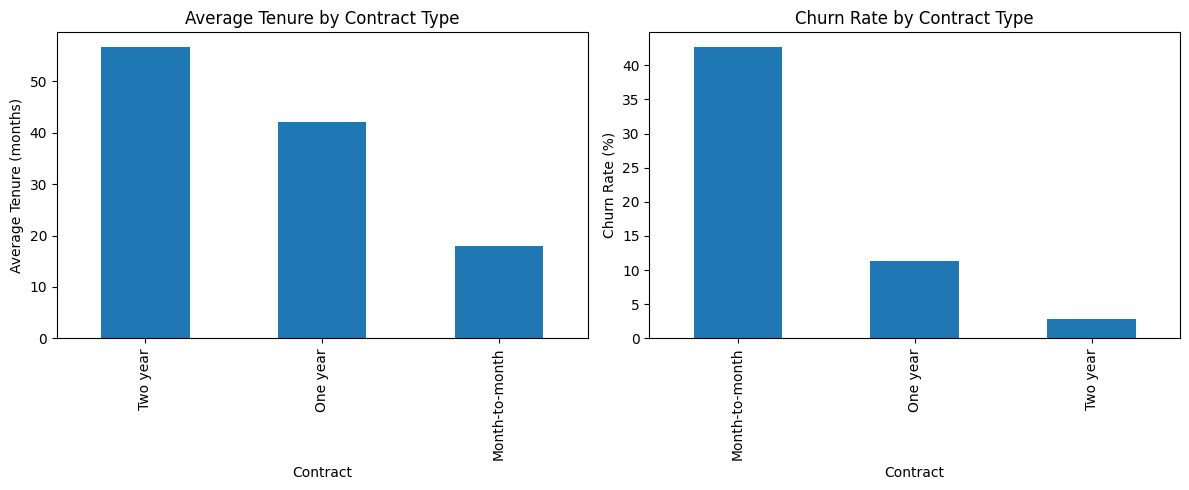


Average Tenure by Contract Type:
Contract
Two year          56.735103
One year          42.044807
Month-to-month    18.036645
Name: tenure, dtype: float64

Churn Rate by Contract Type:
Contract
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Churn, dtype: float64


In [17]:
def analyze_contract_retention():
    # Calculate average tenure by contract type
    avg_tenure = df.groupby('Contract')['tenure'].mean().sort_values(ascending=False)

    # Calculate churn rate by contract type
    churn_by_contract = df.groupby('Contract')['Churn'].mean().sort_values(ascending=False)

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    avg_tenure.plot(kind='bar', ax=ax1)
    ax1.set_title('Average Tenure by Contract Type')
    ax1.set_ylabel('Average Tenure (months)')

    (churn_by_contract * 100).plot(kind='bar', ax=ax2)
    ax2.set_title('Churn Rate by Contract Type')
    ax2.set_ylabel('Churn Rate (%)')

    plt.tight_layout()
    plt.show()

    return avg_tenure, churn_by_contract

#Execute analysis
print("\n=== Contract Type and Retention Analysis ===")
avg_tenure, churn_by_contract = analyze_contract_retention()
print("\nAverage Tenure by Contract Type:")
print(avg_tenure)
print("\nChurn Rate by Contract Type:")
print(churn_by_contract)

**Research Question 3: How do service subscriptions affect customer churn?**


=== Service Impact Analysis ===


<Figure size 1200x600 with 0 Axes>

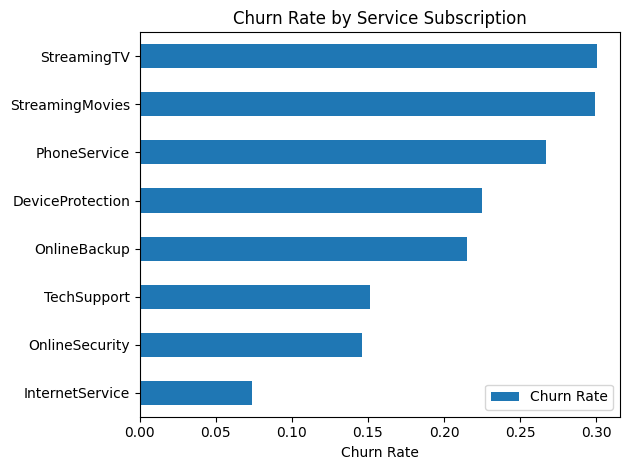

In [19]:
def analyze_service_impact():
    services = ['PhoneService', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies']

    service_impact = {}
    for service in services:
        churn_rate = df.groupby(service)['Churn'].mean()
        service_impact[service] = churn_rate

    # Visualization
    plt.figure(figsize=(12, 6))

    # Create a summary DataFrame for plotting
    impact_df = pd.DataFrame({
        service: rates['Yes'] if 'Yes' in rates else rates.iloc[-1]
        for service, rates in service_impact.items()
    }, index=['Churn Rate']).T

    impact_df.sort_values('Churn Rate', ascending=True).plot(kind='barh')
    plt.title('Churn Rate by Service Subscription')
    plt.xlabel('Churn Rate')
    plt.tight_layout()
    plt.show()

    return service_impact

#Execute Analysis
print("\n=== Service Impact Analysis ===")
service_impact = analyze_service_impact()

**Research Question 4: Can we predict customer churn?**

In [20]:
def build_churn_prediction_model():
    # Prepare features
    features = ['tenure', 'MonthlyCharges', 'TotalCharges']
    X = df[features].fillna(0)
    y = df['Churn']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)

    print("\nModel Performance:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': abs(model.coef_[0])
    }).sort_values('Importance', ascending=False)

    return feature_importance

#Execute predictive model
print("\n=== Churn Prediction Model ===")
feature_importance = build_churn_prediction_model()
print("\nFeature Importance:")
print(feature_importance)


=== Churn Prediction Model ===

Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.48      0.56       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.71      1409
weighted avg       0.79      0.80      0.79      1409


Feature Importance:
          Feature  Importance
0          tenure    0.064003
1  MonthlyCharges    0.029532
2    TotalCharges    0.000127
